In [1]:
import mne
import numpy as np
from matplotlib import pyplot as plt
import math
from scipy import stats, signal
import itertools
import pandas as pd
from datetime import datetime

In [2]:
# consts
threshold_env = 8  
threshold_amp = 5  
threshold_grad = 5
use_env = True
use_amp = True
use_grad = True
block_size_sec = 10  # filter and find peaks at blocks of X seconds - based on Andrillon et al

# the bandpass range is based on Andrillon et al
low_pass = 50
high_pass = 150

# general constants
min_distance = 200  # minimal distance for 'different' spikes - in miliseconds
min_spike_length_sec = 0.004  # a spike is detected if there are points for 5 ms passing the threshold, based on Andrillon et al


In [3]:
def get_markers(data, index_above_threshold, thresh_type):
    max_markers_index = []
    max_marker_value = []

    # find max markers
    #     counter = 1
    curr_spike = []
    curr_spike_data = [thresh_type, index_above_threshold[0]]
    curr_spike.append(index_above_threshold[0])
    for j in range(len(index_above_threshold)):
        # check that the next index is the same spike
        if j + 1 < len(index_above_threshold) and index_above_threshold[j + 1] - index_above_threshold[j] == 1:
            curr_spike.append(index_above_threshold[j + 1])
        # the current spike finished
        else:
            # check min spike length
            if sampling_rate * min_spike_length_sec <= len(curr_spike):
                # check if the peak is positive or negative and append it's value
                max_value = data[curr_spike[0]: curr_spike[-1] + 1].max()
                min_value = data[curr_spike[0]: curr_spike[-1] + 1].min()
                value = max_value if abs(max_value) > abs(min_value) else min_value
                
                # find the index of the spike's peak
                index = np.intersect1d(np.where(data == value)[0], curr_spike)[0]
                max_marker_value.append(value)
                max_markers_index.append(index)
                curr_spike_data.extend((index_above_threshold[j], index, value))
                spikes_list.append(curr_spike_data)
                
            # init data for next spike
            if j + 1 < len(index_above_threshold):
                curr_spike = []
                curr_spike_data = [thresh_type, index_above_threshold[j + 1]]
                
    return np.array(max_markers_index), np.array(max_marker_value)

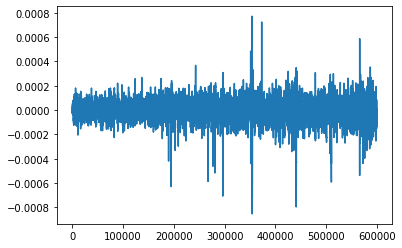

In [29]:
common_spikes_index = []
# format: [spike_id, threshold_type, first_index, last_index, max_index, max_amp, duration(calc once for all after convert to df), sleep_stage?]
spikes_list = []
id = '402_RAH1-RAH2_bi'
# edf = '/Users/rotemfalach/Documents/University/lab/EDFs_forRotem/402_for_tag.edf'
mne.set_log_level(False)
edf = 'C:\\Users\\user\\PycharmProjects\\pythonProject\\results\\402\\402_for_tag.edf'
raw = mne.io.read_raw_edf(edf)
sampling_rate = int(raw.info['sfreq'])
raw.pick_channels(['RAH1-RAH2'])
raw.crop(tmin=0, tmax=300)

data = raw.get_data()[0]
plt.plot(data)

In [33]:
points_in_block = block_size_sec * sampling_rate
number_of_blocks = math.floor(len(data) / points_in_block)
max_markers_index_amp, max_markers_index_grad, max_markers_index_env, all_common_index, all_common_value = [], [], [], [], []

for i in range(number_of_blocks):
    curr_block = data[i * points_in_block: (i + 1) * points_in_block]

    # check amplitude threshold
    if use_amp or use_amp_env or use_amp_grad:
        z_score_amp = stats.zscore(curr_block)
        points_above_thresh_amp = z_score_amp[z_score_amp > threshold_amp]
        # get indexes from z_score values and add offset of the current block
        if len(points_above_thresh_amp) > 0:
            index_above_threshold_amp = (z_score_amp > threshold_amp).nonzero()[0] + i * points_in_block
            max_markers_index_amp, max_marker_value_amp = get_markers(data, index_above_threshold_amp, 'amp')
            print(max_markers_index_amp)

    # check gradient threshold
    if use_grad or use_amp_grad:
        gradient_diff = np.diff(curr_block)
        z_score_grad = stats.zscore(np.insert(gradient_diff, 0, 0))
        points_above_thresh_grad = z_score_grad[z_score_grad > threshold_grad]
        if len(points_above_thresh_grad) > 0:
            index_above_threshold_grad = (z_score_grad > threshold_grad).nonzero()[0] + i * points_in_block
            max_markers_index_grad, max_marker_value_grad = get_markers(data, index_above_threshold_grad, 'grad')

    # check envelope threshold
    if use_env or use_amp_env:
        filtered_block = mne.filter.filter_data(curr_block, sampling_rate, low_pass, high_pass)
        env_block = abs(signal.hilbert(filtered_block))
        z_score_env = stats.zscore(env_block)
        points_above_thresh_env = z_score_env[z_score_env > threshold_env]
        if len(points_above_thresh_env) > 0:
            index_above_threshold_env = (z_score_env > threshold_env).nonzero()[0] + i * points_in_block
            max_markers_index_env, max_marker_value_env = get_markers(data, index_above_threshold_env, 'env')


[373121]


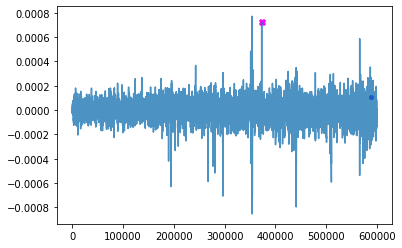

In [31]:
plt.plot(data, alpha=0.8)
plt.scatter(max_markers_index_amp, data[max_markers_index_amp] if len(max_markers_index_amp) > 0 else [], marker='X', color='fuchsia')
plt.plot(max_markers_index_grad, data[max_markers_index_grad] if len(max_markers_index_grad) > 0 else [], marker='P', color='red')
plt.scatter(max_markers_index_env, data[max_markers_index_env] if len(max_markers_index_env) > 0 else [], marker='o', color='blue', s=15)

In [17]:
max_markers_index_grad

array([16191], dtype=int64)

In [32]:
spikes_list

[['grad', 16191, 16211, 16191, -0.00012977798123140266],
 ['grad', 56805, 56828, 56805, -0.0001223010605020214],
 ['grad', 82371, 82398, 82371, -0.0002118715190356294],
 ['grad', 82479, 82487, 82480, -5.1041428244449106e-05],
 ['grad', 123744, 123768, 123768, 0.0002559700923170829],
 ['env', 123744, 123797, 123769, 0.0002584115358205544],
 ['grad', 163993, 164004, 163993, -3.8986800946058936e-05],
 ['grad', 175149, 175169, 175169, 0.00013679713130388386],
 ['grad', 194501, 194528, 194502, -0.00018440527962157585],
 ['env', 194230, 194272, 194262, -0.00012489509422445978],
 ['grad', 208788, 208819, 208788, -0.0001999694819562062],
 ['grad', 209208, 209224, 209209, -0.0001120775158312348],
 ['grad', 239835, 239846, 239835, -5.5466544594491065e-05],
 ['grad', 242823, 242832, 242832, 0.0001114671549553678],
 ['grad', 242865, 242885, 242885, 0.0003521019302662704],
 ['env', 242855, 242878, 242878, 0.0002535286488136115],
 ['grad', 277014, 277040, 277014, -0.00027351796749828296],
 ['grad', 

In [9]:
x = [1, 2, 3, 4]
x[-1]

4

In [26]:
spike_indexes = np.arange(spikes_list[0][1], spikes_list[0][2] + 1 )

In [27]:
data[spike_indexes]

array([-1.29777981e-04, -1.25352865e-04, -1.20622568e-04, -1.15587091e-04,
       -1.10551614e-04, -1.05210956e-04, -9.98702983e-05, -9.45296407e-05,
       -8.91889830e-05, -8.38483253e-05, -7.88128481e-05, -7.37773709e-05,
       -6.87418936e-05, -6.40115969e-05, -5.92813001e-05, -5.45510033e-05,
       -4.99732967e-05, -4.55481804e-05, -4.11230640e-05, -3.68505379e-05,
       -3.24254215e-05])

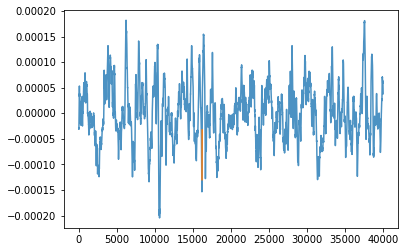

In [28]:
plt.plot(data, alpha=0.8)
plt.plot(spike_indexes, data[spike_indexes])